<a name='0_0'></a>
# <span style="color:#ff5f27">👨🏻‍🏫 Deep Neural Networks with Keras </span>

🗄️ Table of Contents:

- [📝 Imports](#0)
- [👨🏻‍🏫 Task 1 - Hourly Wages Prediction](#1)
    - [🗄️ Data Preparation](#2)
    - [👩🏻‍🔬 Model Building](#3)
    - [⚖️ Best models comparison](#4)
    - [🤖 Final Model](#4.1)
- [👨🏻‍🏫 Task 2 - Diabetes](#5)
    - [🗄️ Data Preparation](#6)
    - [👩🏻‍🔬 Model Building](#7)
    - [⚖️ Best models comparison](#8)
    - [🤖 Final Model](#8.1)
- [👨🏻‍🏫 Used Cars Price Prediction](#9)
    - [🗄️ Data Preparation](#10)
    - [👩🏻‍🔬 Model Building](#11)
    - [👮🏻‍♂️ Model Evaluation](#12)

<a name='0'></a>
## <span style="color:#ff5f27">📝 Imports </span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import os
import random

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score

from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

2023-10-03 23:05:12.591808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def reset_seeds(seed_value=24):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value) 
    random.seed(seed_value)
    set_seed(seed_value)

In [3]:
def train_val_test_split(data, target_column, val_size=0.2, test_size=0.1, seed=24):
    # Shuffle the data
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    data = data.iloc[shuffled_indices]
    
    # Calculate the sizes of the splits
    num_samples = len(data)
    val_size = int(num_samples * val_size)
    test_size = int(num_samples * test_size)
    
    # Split the data
    val_data = data[:val_size]
    test_data = data[val_size:(val_size + test_size)]
    train_data = data[(val_size + test_size):]
    
    # Check if split is correct
    assert train_data.shape[0] + val_data.shape[0] + test_data.shape[0] == data.shape[0]
    
    # Separate features and target for each split
    train_X = train_data.drop(columns=[target_column])
    val_X = val_data.drop(columns=[target_column])
    test_X = test_data.drop(columns=[target_column])
    train_y = train_data[target_column]
    val_y = val_data[target_column]
    test_y = test_data[target_column]
    
    return train_X, val_X, test_X, train_y, val_y, test_y

In [4]:
def scale_df(columns_to_scale, data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[columns_to_scale])    
    data[columns_to_scale] = data_scaled
    return data

In [5]:
def normalize_df(columns_to_normalize, data):
    normalizer = Normalizer()
    data_normalized = normalizer.fit_transform(data[columns_to_normalize])    
    data[columns_to_normalize] = data_normalized
    return data

---
<a name='1'></a>
## <span style="color:#ff5f27"> 💰 Hourly Wages Prediction </span>

- [🗄️ Table of Contents](#0_0)

<a name='2'></a>
## <span style="color:#ff5f27"> 🗄️ Data Preparation</span>

In [6]:
data_wages = pd.read_csv('data/hourly_wages_data.csv')
data_wages.head(3)

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,0,8,21,35,1,1,0,1,0
1,4.95,0,9,42,57,1,1,0,1,0
2,6.67,0,12,1,19,0,0,0,1,0


In [7]:
data_wages.shape

(534, 10)

In [8]:
data_wages.isna().sum()

wage_per_hour     0
union             0
education_yrs     0
experience_yrs    0
age               0
female            0
marr              0
south             0
manufacturing     0
construction      0
dtype: int64

In [9]:
duplicated = data_wages[data_wages.drop('wage_per_hour', axis=1).duplicated()]
print(duplicated.shape)
duplicated.head(4)

(54, 10)


,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
9,8.75,0,12,9,27,0,0,0,0,0
22,3.75,0,12,9,27,0,0,0,0,0
94,19.98,0,12,23,41,0,1,0,1,0
103,9.83,0,12,23,41,0,1,0,1,0


In [10]:
data_wages.drop(duplicated.index, inplace=True)

In [11]:
data_wages.shape

(480, 10)

In [12]:
data_wages[data_wages.drop('wage_per_hour', axis=1).duplicated()]

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction


In [13]:
Q1 = data_wages['wage_per_hour'].quantile(0.25)
Q3 = data_wages['wage_per_hour'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_wages[
    (data_wages['wage_per_hour'] < lower_bound) | (data_wages['wage_per_hour'] > upper_bound)
]
print(f"Amount of outliers: {len(outliers)}")

data_wages = data_wages[(data_wages['wage_per_hour'] >= lower_bound) & (data_wages['wage_per_hour'] <= upper_bound)]

Amount of outliers: 23


### <span style="color:#ff5f27">🪓 Raw Data Split</span>

In [14]:
train_X, val_X, test_X, train_y, val_y, test_y = train_val_test_split(
    data_wages,
    'wage_per_hour',
)

### <span style="color:#ff5f27">🧬 Scaler</span>

In [15]:
data_wages_scaled = scale_df(['union', 'education_yrs', 'experience_yrs', 'age'], data_wages)
data_wages_scaled.head(3)

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,-0.498632,-1.836298,0.237161,-0.162806,1,1,0,1,0
1,4.95,-0.498632,-1.460317,1.916888,1.712170,1,1,0,1,0
2,6.67,-0.498632,-0.332376,-1.362580,-1.526425,0,0,0,1,0


In [16]:
round(data_wages_scaled['age'].mean()), round(data_wages_scaled['age'].std(),1)

(0, 1.0)

### <span style="color:#ff5f27">🪓 Scaled Split</span>

In [17]:
train_X_scaled, val_X_scaled, test_X_scaled, train_y, val_y, test_y = train_val_test_split(
    data_wages_scaled,
    'wage_per_hour',
)

### <span style="color:#ff5f27">🧬 Normalization</span>

In [18]:
data_wages_normalized = normalize_df(['union', 'education_yrs', 'experience_yrs', 'age'], data_wages)
data_wages_normalized.head(3)

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,-0.259108,-0.954211,0.123238,-0.084600,1,1,0,1,0
1,4.95,-0.166330,-0.487120,0.639419,0.571131,1,1,0,1,0
2,6.67,-0.233873,-0.155894,-0.639089,-0.715937,0,0,0,1,0


### <span style="color:#ff5f27">🪓 Normalized Split</span>

In [19]:
train_X_normalized, val_X_normalized, test_X_normalized, train_y, val_y, test_y = train_val_test_split(
    data_wages_normalized,
    'wage_per_hour',
)

<a name='3'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Model Building</span>

In [20]:
def create_model(layers:list, activation:str, optimizer:str='Adam', task:str='regression'):
    reset_seeds()
    model = Sequential()
    
    activations = [activation for i in range(len(layers))]
        
    for layer, activation in zip(layers, activations):
        model.add(Dense(
            layer,
            activation=activation
        ))
        
    if task == 'regression':
        model.add(Dense(1, activation='relu'))
        model.compile(
            optimizer=optimizer,
            loss='mean_squared_error',
        )
    elif task == 'classification':
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )

    return model

In [21]:
def model_experiment(train_X, val_X, test_X, train_y, val_y, test_y, task:str):
    
    def generate_neurons(n):
        return [2**i for i in range(4,n+1)][::-1]
    
    activations = ['relu', 'tanh']
    optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
    
    early_stopping_monitor = EarlyStopping(patience=3)
    neurons_n = {n: generate_neurons(n) for n in [5,6]}
    history = {}
    models = {}
    fit_times = {}
    
    for activation in activations:
        for n, neurons in neurons_n.items():
            for optimizer in optimizers:
                model = create_model(neurons, activation, optimizer, task)
                
                start_time = time.time()
                
                history[f'{activation}_2^{n}_{optimizer}'] = model.fit(
                    train_X, 
                    train_y, 
                    validation_data=(val_X, val_y),
                    epochs=30,
                    batch_size=32,
                    callbacks=[early_stopping_monitor],
                    verbose=0,
                )
                
                end_time = time.time()
                fit_time = end_time - start_time
                
                fit_times[f'{activation}_2^{n}_{optimizer}'] = fit_time
                
                models[f'{activation}_2^{n}_{optimizer}'] = model
                
    return history, models, fit_times

In [22]:
def select_best_models(history_dict, best_n=4, weight_train=0.3, weight_val=0.7):
    best_models = []

    for model_name, history in history_dict.items():
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        weighted_mean_loss = (weight_train * train_loss[-1] + weight_val * val_loss[-1])

        best_models.append((model_name, weighted_mean_loss, history))

    best_models.sort(key=lambda x: x[1])
    best_model_names = [model_info[0] for model_info in best_models]
    return best_model_names[:best_n]

In [23]:
def plot_best_models(histories, best_models):    
    n_rows = math.ceil(len(best_models) / 2)
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

    for i, model_name in enumerate(best_models):
        row = i // n_cols
        col = i % n_cols

        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        history = histories[model_name]
        ax.plot(history.history['loss'], label=f'{model_name} - Train')
        ax.plot(history.history['val_loss'], label=f'{model_name} - Validation')
        ax.set_title(f'Model Loss ({model_name})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(loc='upper right')
    plt.tight_layout(pad=1)

## <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Untransformed Data</span>

In [24]:
history_untransformed, models_untransformed, time_untransformed = model_experiment(
    train_X, val_X, test_X, train_y, val_y, test_y, 'regression'
)

2023-10-03 23:05:18.474803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


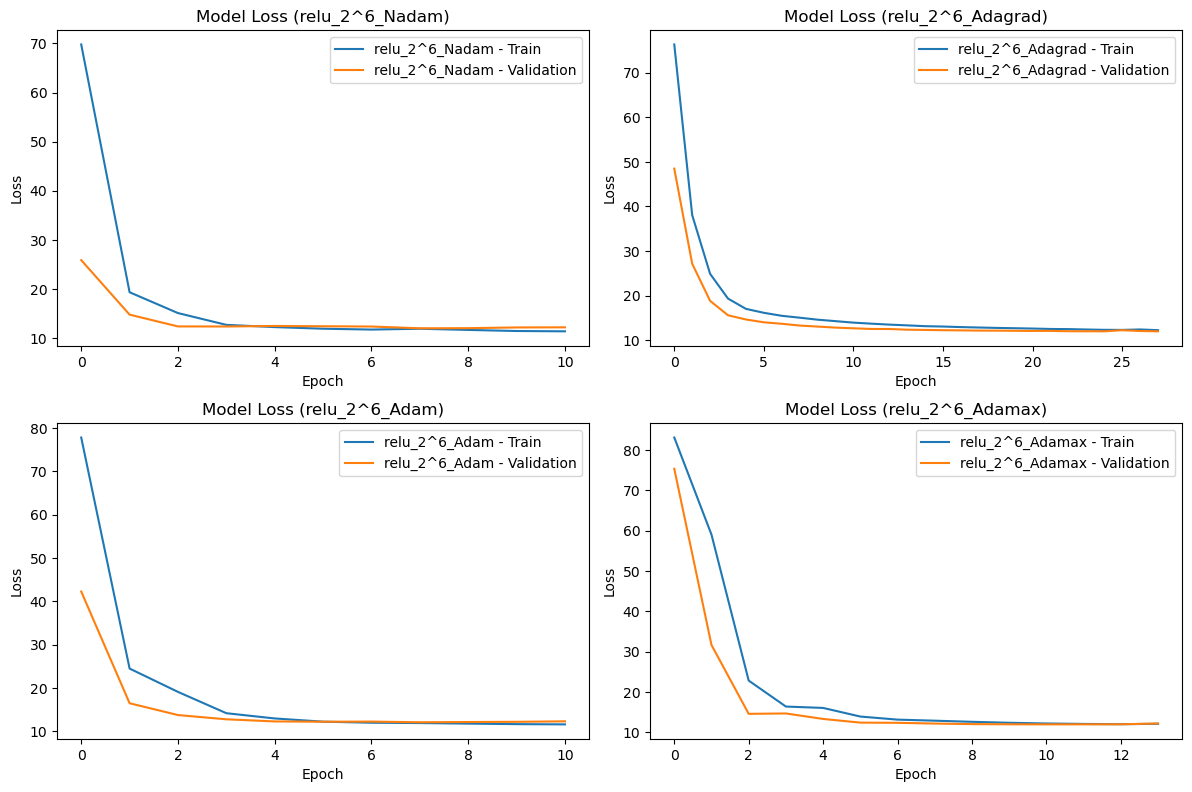

In [25]:
best_models_untransformed = select_best_models(history_untransformed)
plot_best_models(history_untransformed, best_models_untransformed)

## <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Scaled Data</span>

In [26]:
history_scaled, models_scaled, time_scaled = model_experiment(
    train_X_scaled, val_X_scaled, test_X_scaled, train_y, val_y, test_y, 'regression'
)

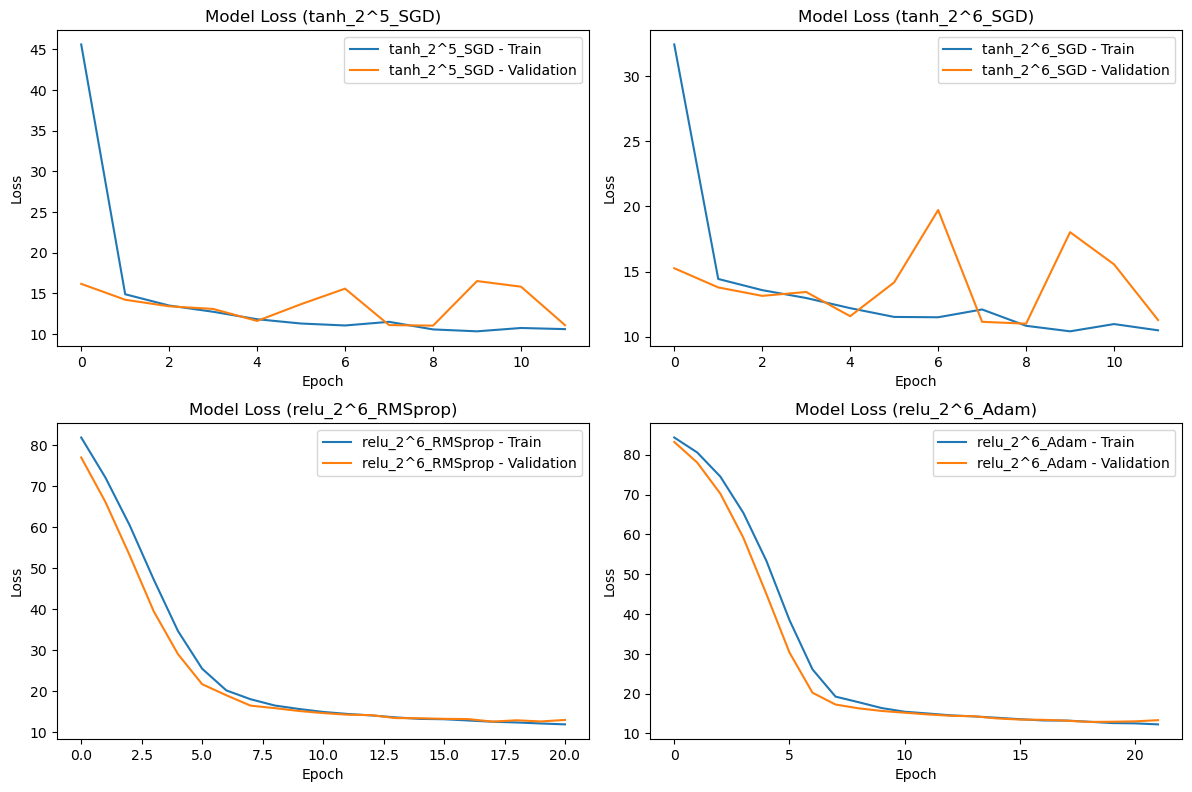

In [27]:
best_models_scaled = select_best_models(history_scaled)
plot_best_models(history_scaled, best_models_scaled)

## <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Normalized Data</span>

In [28]:
history_normalized, models_normalized, time_normalized = model_experiment(
    train_X_normalized, val_X_normalized, test_X_normalized, train_y, val_y, test_y, 'regression'
)

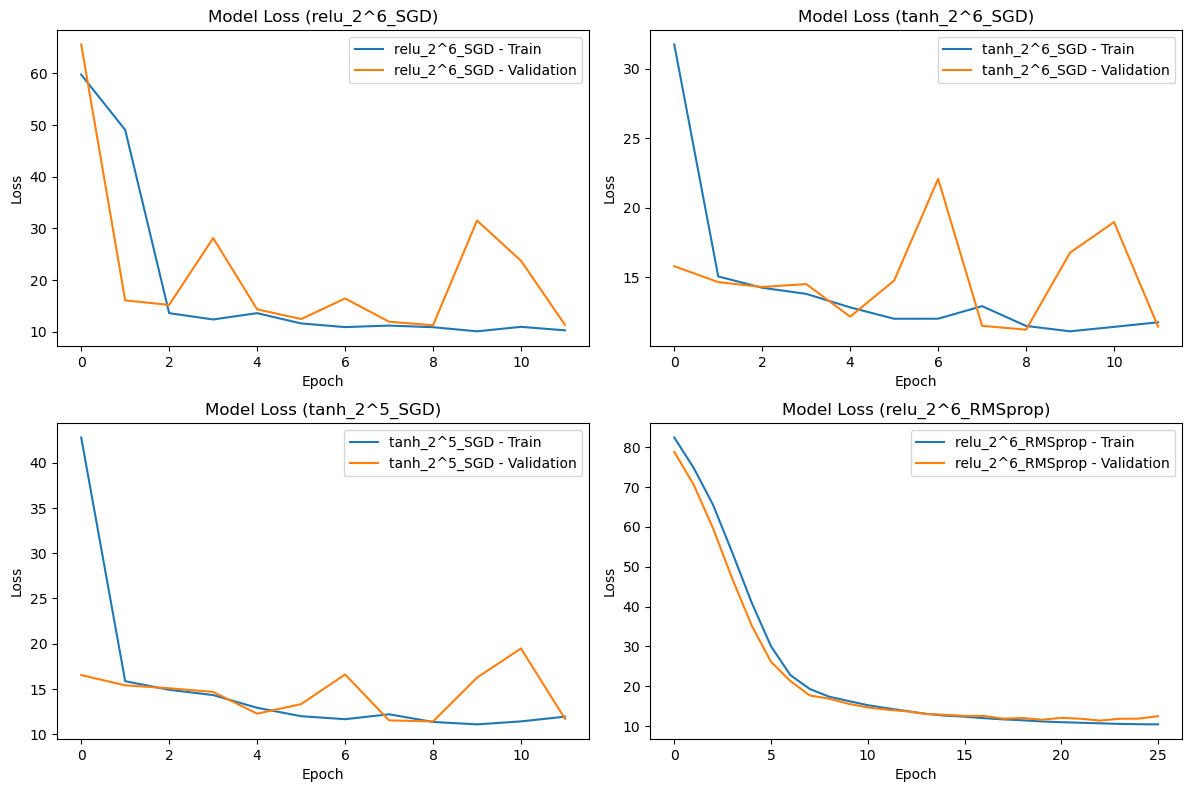

In [29]:
best_models_normalized = select_best_models(history_normalized)
plot_best_models(history_normalized, best_models_normalized)

<a name='4'></a>
## <span style="color:#ff5f27">⚖️ Best models comparison</span>

In [30]:
best_model_untransformed = models_untransformed[best_models_untransformed[0]]
best_model_scaled = models_scaled[best_models_scaled[0]]
best_model_normalized = models_normalized[best_models_normalized[0]]

In [31]:
def test_model_regression(test_data, real_data, model):
    preds = model.predict(test_data)
    return mean_squared_error(real_data, preds)

In [32]:
print(f'⚙️ Best Model Architecture: {best_models_untransformed[0]}')
print(f'⌛️ Fit Time: {round(time_untransformed[best_models_untransformed[0]],2)}sec')
print(f'⛳️ MSE untransformed model: {round(test_model_regression(test_X, test_y, best_model_untransformed),2)}')

⚙️ Best Model Architecture: relu_2^6_Nadam
⌛️ Fit Time: 1.64sec
2/2 [==============================] - 0s 2ms/step
⛳️ MSE untransformed model: 12.96


In [33]:
print(f'⚙️ Best Model Architecture: {best_models_scaled[0]}')
print(f'⌛️ Fit Time: {round(time_scaled[best_models_scaled[0]],2)}sec')
print(f'⛳️ MSE scaled model: {round(test_model_regression(test_X_scaled, test_y, best_model_scaled),2)}')

⚙️ Best Model Architecture: tanh_2^5_SGD
⌛️ Fit Time: 0.78sec
2/2 [==============================] - 0s 2ms/step
⛳️ MSE scaled model: 12.01


In [34]:
print(f'⚙️ Best Model Architecture: {best_models_normalized[0]}')
print(f'⌛️ Fit Time: {round(time_normalized[best_models_normalized[0]],2)}sec')
print(f'⛳️ MSE normalized model: {round(test_model_regression(test_X_normalized, test_y, best_model_normalized),2)}')

⚙️ Best Model Architecture: relu_2^6_SGD
⌛️ Fit Time: 0.84sec
2/2 [==============================] - 0s 2ms/step
⛳️ MSE normalized model: 10.52


<a name='4.1'></a>
## <span style="color:#ff5f27">🤖 Final Model </span>

In [35]:
reset_seeds()

model_final = Sequential()
model_final.add(Dense(64, activation='relu'))  
model_final.add(Dropout(0.2))
model_final.add(Dense(32, activation='relu'))  
model_final.add(Dropout(0.1))
model_final.add(Dense(16, activation='relu')) 
model_final.add(Dense(1, activation='relu'))
model_final.compile(optimizer='adam', loss='mean_squared_error') 

history_final = model_final.fit(
    train_X_normalized,
    train_y, 
    validation_data=(val_X_normalized, val_y), 
    epochs=30, 
)

Epoch 1/30
11/11 [==============================] - 1s 13ms/step - loss: 84.3358 - val_loss: 83.7080
Epoch 2/30
11/11 [==============================] - 0s 3ms/step - loss: 81.4878 - val_loss: 79.8184
Epoch 3/30
11/11 [==============================] - 0s 4ms/step - loss: 76.4540 - val_loss: 73.7140
Epoch 4/30
11/11 [==============================] - 0s 4ms/step - loss: 68.9531 - val_loss: 64.5502
Epoch 5/30
11/11 [==============================] - 0s 4ms/step - loss: 58.8909 - val_loss: 52.0958
Epoch 6/30
11/11 [==============================] - 0s 4ms/step - loss: 45.5798 - val_loss: 38.0259
Epoch 7/30
11/11 [==============================] - 0s 4ms/step - loss: 32.0929 - val_loss: 25.4257
Epoch 8/30
11/11 [==============================] - 0s 4ms/step - loss: 22.5773 - val_loss: 19.1596
Epoch 9/30
11/11 [==============================] - 0s 4ms/step - loss: 20.6973 - val_loss: 17.3003
Epoch 10/30
11/11 [==============================] - 0s 4ms/step - loss: 17.6790 - val_loss: 16.295

Text(0, 0.5, 'Loss')

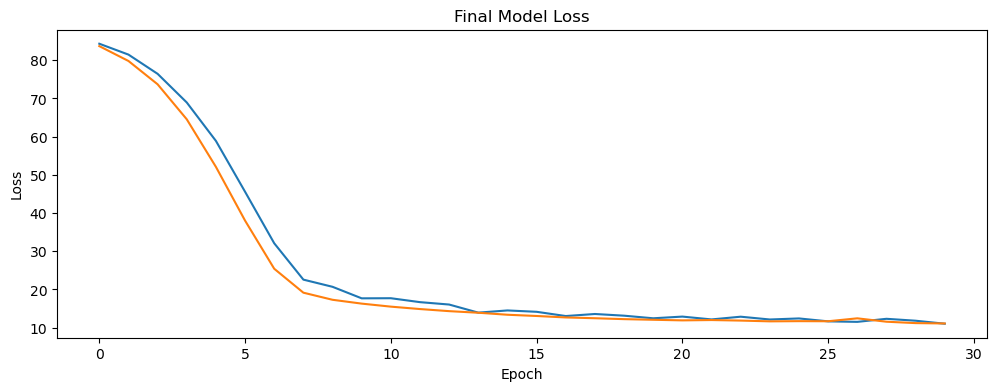

In [36]:
plt.figure(figsize=(12,4))
plt.plot(history_final.history['loss'], label=f'Train')
plt.plot(history_final.history['val_loss'], label=f'Validation')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [37]:
print(f'⛳️ MSE final model: {round(test_model_regression(test_X_normalized, test_y, model_final),2)}')

2/2 [==============================] - 0s 2ms/step
⛳️ MSE final model: 10.67


---
<a name='5'></a>
## <span style="color:#ff5f27">🔬 Diabetes Prediction </span>
- [🗄️ Table of Contents](#0_0)

<a name='6'></a>
## <span style="color:#ff5f27">🗄️ Data Preparation </span>

In [38]:
data_diabetes = pd.read_csv('data/diabetes_data.csv')
data_diabetes.diabetes = data_diabetes.diabetes.astype('category')
data_diabetes.diabetes = data_diabetes.diabetes.cat.codes
data_diabetes.head(3)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [39]:
data_diabetes.shape

(768, 9)

In [40]:
data_diabetes.diabetes.value_counts()

0    500
1    268
Name: diabetes, dtype: int64

In [41]:
data_diabetes.isna().sum()

pregnancies    0
glucose        0
diastolic      0
triceps        0
insulin        0
bmi            0
dpf            0
age            0
diabetes       0
dtype: int64

In [42]:
data_diabetes[data_diabetes.drop('diabetes', axis=1).duplicated()]

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes


### <span style="color:#ff5f27">🪓 Raw Data Split</span>

In [43]:
train_X, val_X, test_X, train_y, val_y, test_y = train_val_test_split(
    data_diabetes,
    'diabetes',
)
train_X.head(3)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
547,4,131,68,21,166,33.1,0.160,28
90,1,80,55,0,0,19.1,0.258,21
662,8,167,106,46,231,37.6,0.165,43


In [44]:
train_y.head(3)

547    0
90     0
662    1
Name: diabetes, dtype: int8

### <span style="color:#ff5f27">🧬 Scaler</span>

In [45]:
data_diabetes_scaled = scale_df([*data_diabetes.drop('diabetes',axis=1).columns], data_diabetes)
data_diabetes_scaled.head(3)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1


In [46]:
round(data_diabetes_scaled.pregnancies.mean()), round(data_diabetes_scaled.pregnancies.std(),1)

(0, 1.0)

### <span style="color:#ff5f27">🪓 Scaled Split</span>

In [47]:
train_X_scaled, val_X_scaled, test_X_scaled, train_y, val_y, test_y = train_val_test_split(
    data_diabetes_scaled,
    'diabetes',
)

### <span style="color:#ff5f27">🧬 Normalization</span>

In [48]:
data_diabetes_normalized = normalize_df([*data_diabetes.drop('diabetes',axis=1).columns], data_diabetes)
data_diabetes_normalized.head(3)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,0.293647,0.389263,0.068664,0.416311,-0.317941,0.093614,0.214973,0.654334,1
1,-0.458093,-0.609101,-0.087047,0.287852,-0.375682,-0.371091,-0.197934,-0.103381,0
2,0.408951,0.644218,-0.087479,-0.426959,-0.229648,-0.365657,0.200318,-0.034994,1


### <span style="color:#ff5f27">🪓 Normalized Split</span>

In [49]:
train_X_normalized, val_X_normalized, test_X_normalized, train_y, val_y, test_y = train_val_test_split(
    data_diabetes_normalized,
    'diabetes',
)

<a name='7'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Model Building</span>

In [50]:
def plot_best_models_accuracy(histories, best_models):    
    n_rows = math.ceil(len(best_models) / 2)
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

    for i, model_name in enumerate(best_models):
        row = i // n_cols
        col = i % n_cols

        if n_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        history = histories[model_name]
        ax.plot(history.history['accuracy'], label=f'{model_name} - Train Accuracy')
        ax.plot(history.history['val_accuracy'], label=f'{model_name} - Validation Accuracy')
        ax.set_title(f'Model Accuracy ({model_name})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower right') 
    plt.tight_layout(pad=1)
    plt.show()

### <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Untransformed Data</span>

In [51]:
history_untransformed, models_untransformed, time_untransformed = model_experiment(
    train_X, val_X, test_X, train_y, val_y, test_y, 'classification',
)

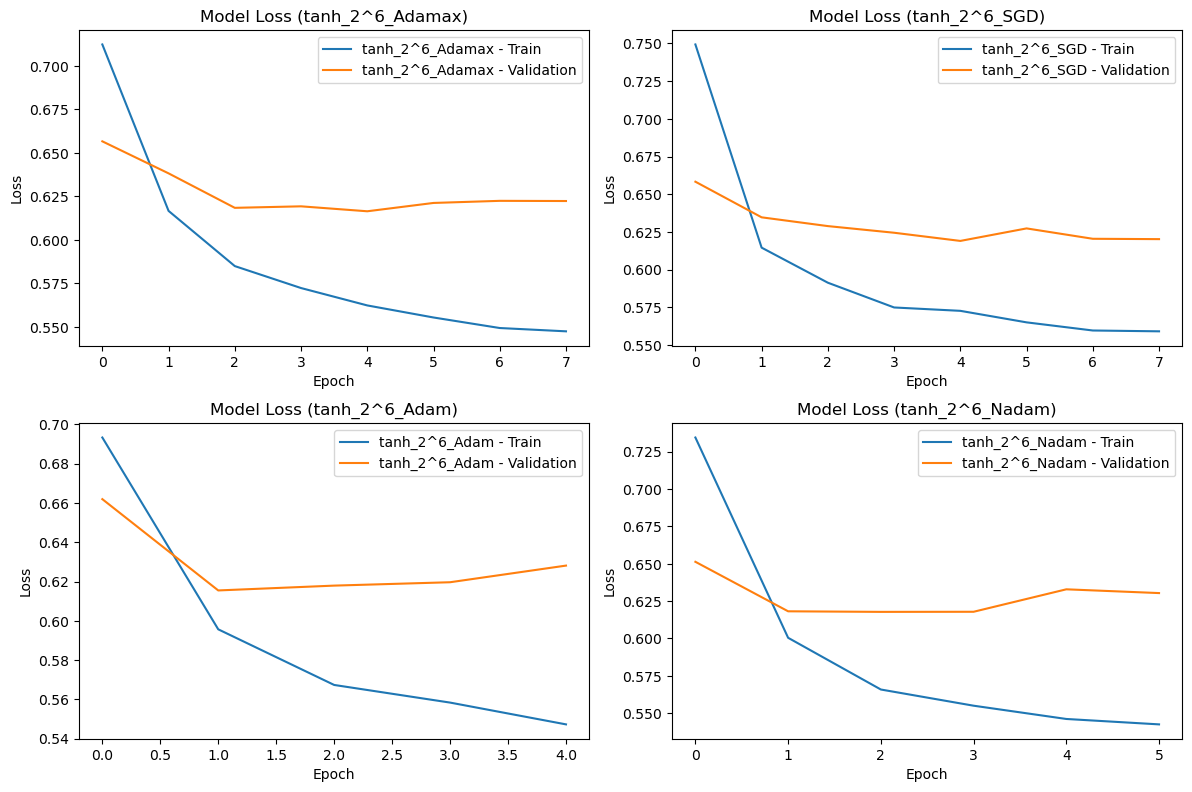

In [52]:
best_models_untransformed = select_best_models(history_untransformed)
plot_best_models(history_untransformed, best_models_untransformed)

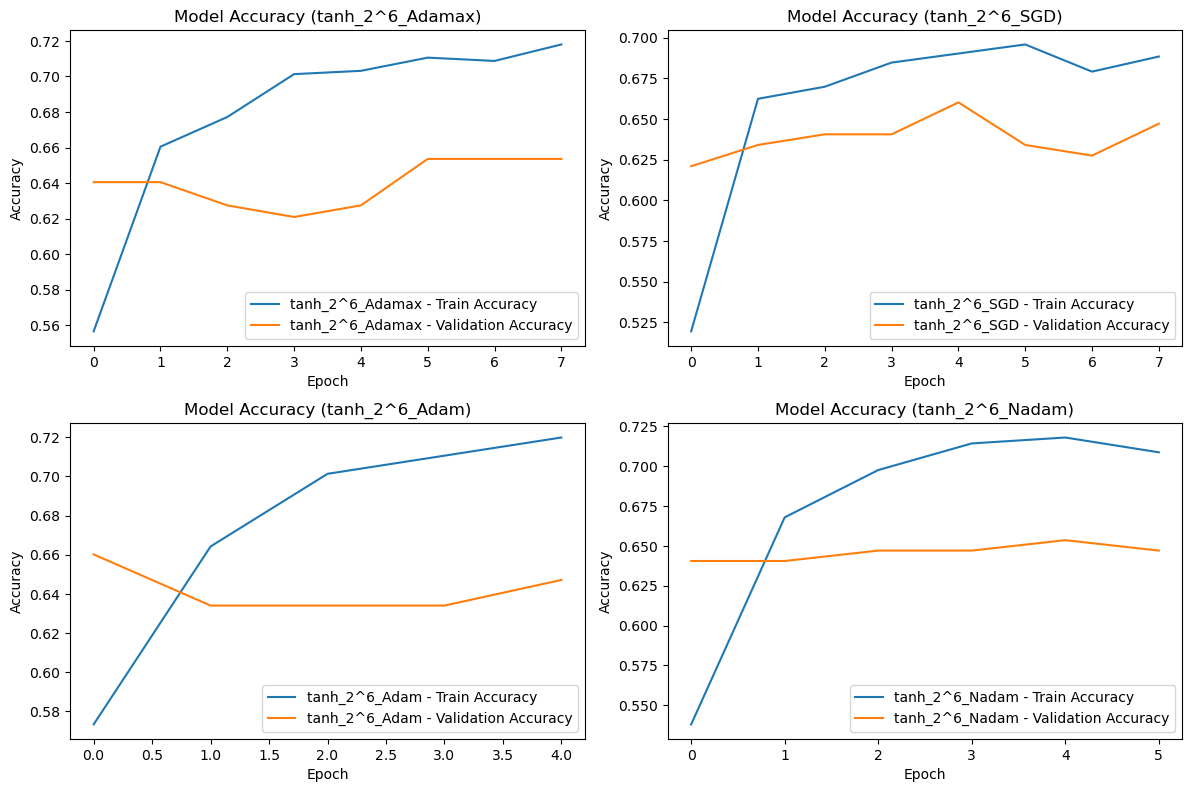

In [53]:
plot_best_models_accuracy(history_untransformed, best_models_untransformed)

## <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Scaled Data</span>

In [54]:
history_scaled, models_scaled, time_scaled = model_experiment(
    train_X_scaled, val_X_scaled, test_X_scaled, train_y, val_y, test_y, 'classification',
)

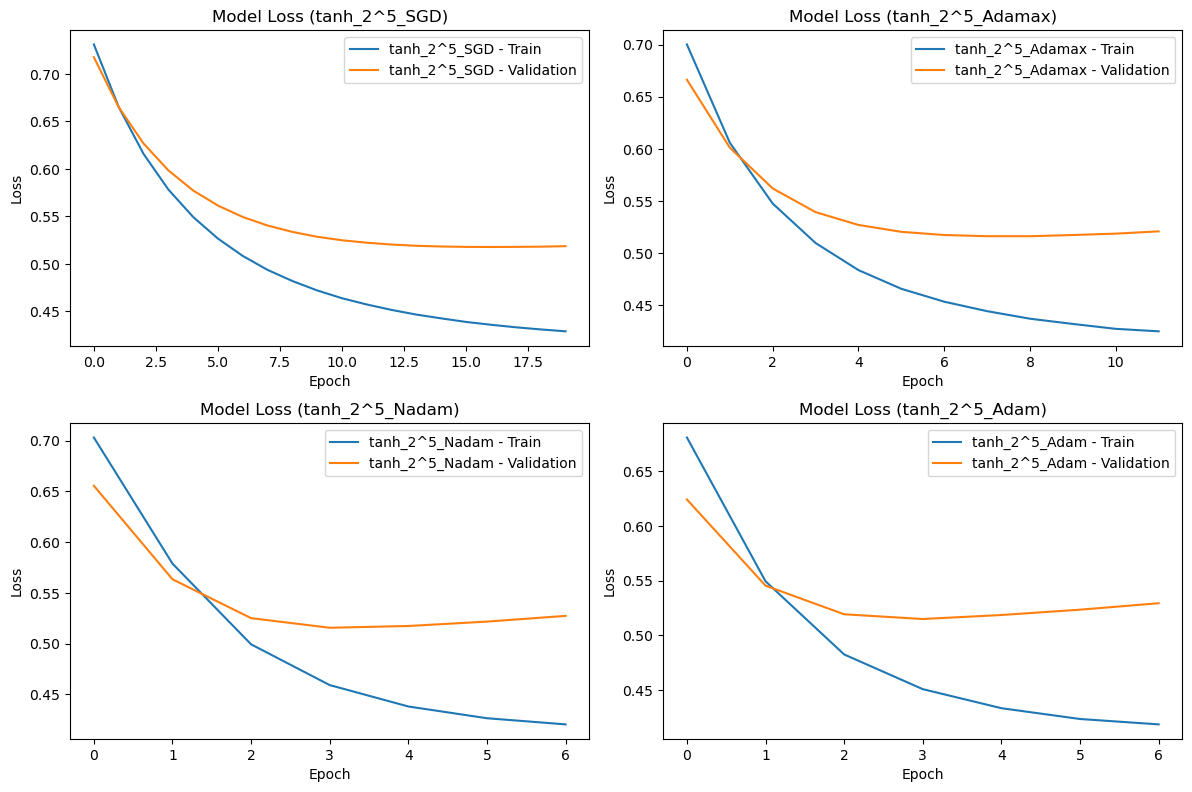

In [55]:
best_models_scaled = select_best_models(history_scaled)
plot_best_models(history_scaled, best_models_scaled)

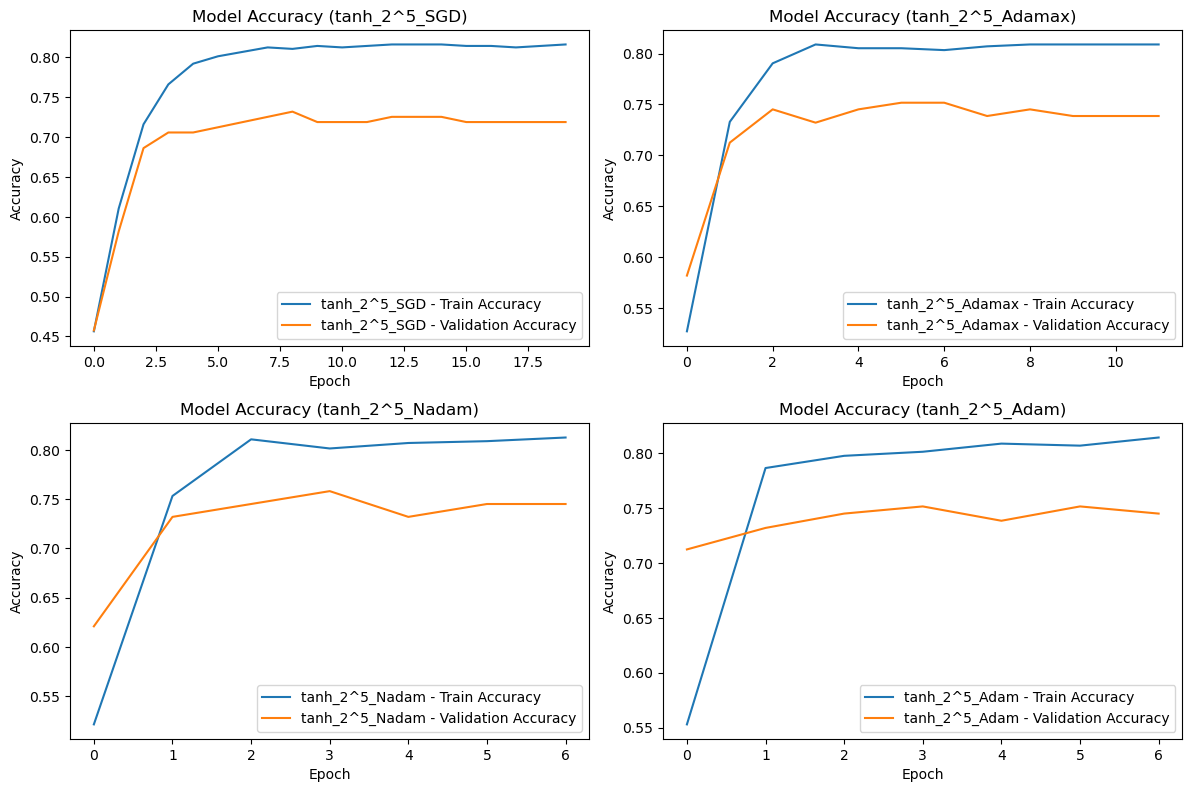

In [56]:
plot_best_models_accuracy(history_scaled, best_models_scaled)

## <span style="color:#ff5f27"> 👩🏻‍🔬 Experiments Normalized Data</span>

In [57]:
history_normalized, models_normalized, time_normalized = model_experiment(
    train_X_normalized, val_X_normalized, test_X_normalized, train_y, val_y, test_y, 'classification'
)

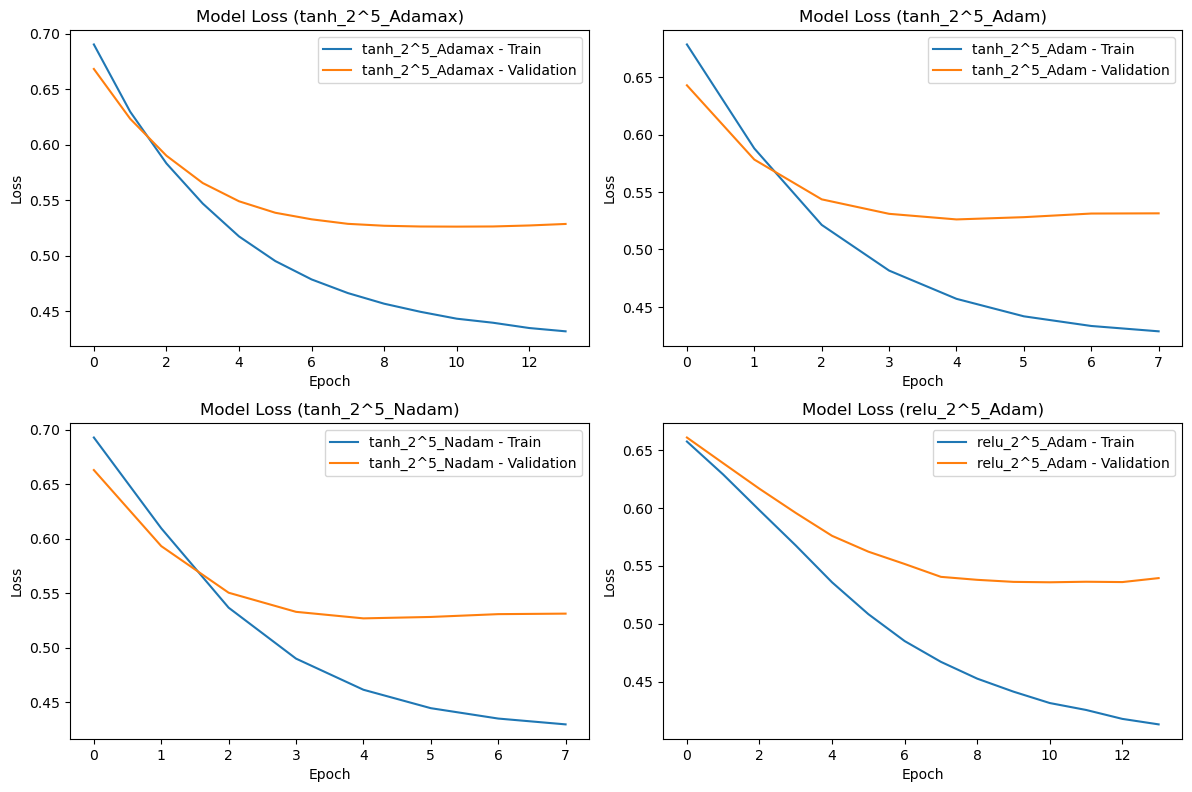

In [58]:
best_models_normalized = select_best_models(history_normalized)
plot_best_models(history_normalized, best_models_normalized)

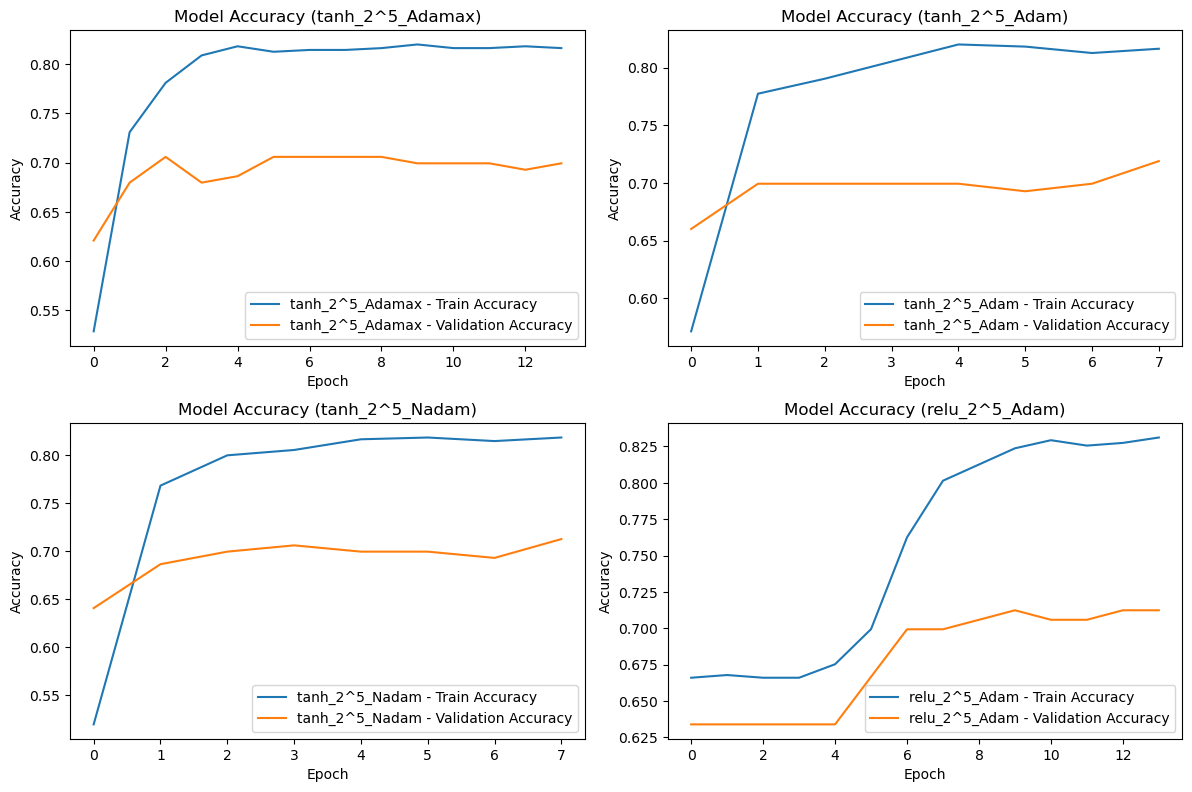

In [59]:
plot_best_models_accuracy(history_normalized, best_models_normalized)

<a name='8'></a>
## <span style="color:#ff5f27">⚖️ Best models comparison</span>

In [60]:
best_model_untransformed = models_untransformed[best_models_untransformed[0]]
best_model_scaled = models_scaled[best_models_scaled[0]]
best_model_normalized = models_normalized[best_models_normalized[0]]

In [61]:
def test_model_classification(test_data, real_data, model):
    preds = (model.predict(test_data) >= 0.5).astype(int)
    return accuracy_score(real_data, preds)

In [62]:
print(f'⚙️ Best Model Architecture: {best_models_untransformed[0]}')
print(f'⌛️ Fit Time: {round(time_untransformed[best_models_untransformed[0]],2)}sec')
print(f'⛳️ Accuracy untransformed model on test data: {round(test_model_classification(test_X, test_y, best_model_untransformed),2)}%')

⚙️ Best Model Architecture: tanh_2^6_Adamax
⌛️ Fit Time: 1.09sec
3/3 [==============================] - 0s 2ms/step
⛳️ Accuracy untransformed model on test data: 0.55%


In [63]:
print(f'⚙️ Best Model Architecture: {best_models_scaled[0]}')
print(f'⌛️ Fit Time: {round(time_scaled[best_models_scaled[0]],2)}sec')
print(f'⛳️ Accuracy scaled model on test data: {round(test_model_classification(test_X_scaled, test_y, best_model_scaled),2)}%')

⚙️ Best Model Architecture: tanh_2^5_SGD
⌛️ Fit Time: 1.25sec
3/3 [==============================] - 0s 2ms/step
⛳️ Accuracy scaled model on test data: 0.62%


In [64]:
print(f'⚙️ Best Model Architecture: {best_models_normalized[0]}')
print(f'⌛️ Fit Time: {round(time_normalized[best_models_normalized[0]],2)}sec')
print(f'⛳️ Accuracy normalized model on test data: {round(test_model_classification(test_X_normalized, test_y, best_model_normalized),2)}%')

⚙️ Best Model Architecture: tanh_2^5_Adamax
⌛️ Fit Time: 1.17sec
3/3 [==============================] - 0s 2ms/step
⛳️ Accuracy normalized model on test data: 0.59%


<a name='8.1'></a>
## <span style="color:#ff5f27">🤖 Final Model </span>

In [65]:
reset_seeds()

model_final = Sequential()
model_final.add(Dense(32, activation='relu'))
model_final.add(Dropout(0.65))
model_final.add(Dense(16, activation='relu'))
model_final.add(Dropout(0.6))
model_final.add(Dense(8, activation='relu'))
model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
) 

history_final = model_final.fit(
    train_X_normalized,
    train_y, 
    validation_data=(val_X_normalized, val_y), 
    epochs=30, 
)

Epoch 1/30
17/17 [==============================] - 1s 9ms/step - loss: 0.6684 - val_loss: 0.6799
Epoch 2/30
17/17 [==============================] - 0s 2ms/step - loss: 0.6639 - val_loss: 0.6685
Epoch 3/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6468 - val_loss: 0.6578
Epoch 4/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6425 - val_loss: 0.6460
Epoch 5/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6362 - val_loss: 0.6362
Epoch 6/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6175 - val_loss: 0.6263
Epoch 7/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6163 - val_loss: 0.6167
Epoch 8/30
17/17 [==============================] - 0s 3ms/step - loss: 0.5972 - val_loss: 0.6083
Epoch 9/30
17/17 [==============================] - 0s 3ms/step - loss: 0.6032 - val_loss: 0.5998
Epoch 10/30
17/17 [==============================] - 0s 3ms/step - loss: 0.5961 - val_loss: 0.5922
Epoch 11/30
17/17 [

Text(0, 0.5, 'Loss')

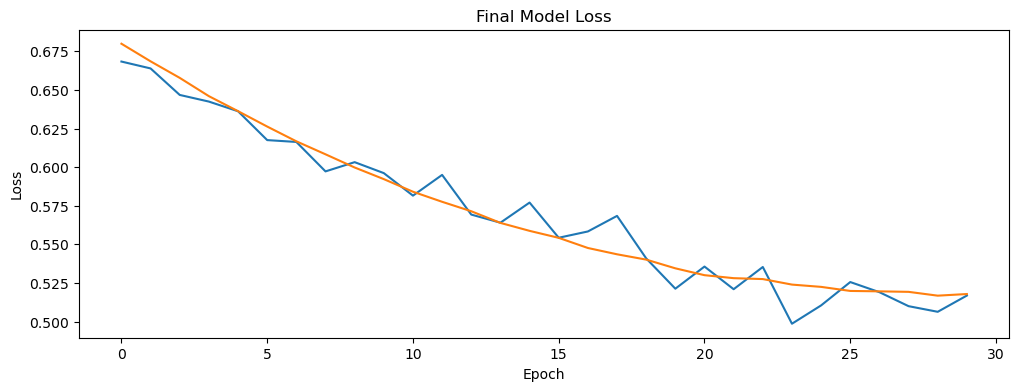

In [66]:
plt.figure(figsize=(12,4))
plt.plot(history_final.history['loss'], label=f'Train')
plt.plot(history_final.history['val_loss'], label=f'Validation')
plt.title('Final Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [67]:
print(f'⛳️ MSE final model: {round(test_model_classification(test_X_normalized, test_y, model_final),2)}')

3/3 [==============================] - 0s 2ms/step
⛳️ MSE final model: 0.62


---
<a name='9'></a>
## <span style="color:#ff5f27">🚗 Used Cars Price Prediction </span>
- [🗄️ Table of Contents](#0_0)

<a name='10'></a>
## <span style="color:#ff5f27">🗄️ Data Preparation </span>

In [68]:
data_cars = pd.read_csv('data/toyota.csv')
data_cars.drop('year', axis=1, inplace=True)
data_cars.head(3)

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,13998,Manual,27469,Petrol,265,36.2,2.0


In [69]:
data_cars.shape

(6738, 8)

In [70]:
data_cars.isna().sum()

model           0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

### <span style="color:#ff5f27">🧬 Scaler</span>

In [71]:
data = scale_df(
    ['mileage', 'tax', 'mpg', 'engineSize'], data_cars,
)
data.head(3)

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,16000,Manual,0.064400,Petrol,2.305274,-1.695063,1.21227
1,GT86,15995,Manual,-0.221837,Petrol,0.680915,-1.695063,1.21227
2,GT86,13998,Manual,0.241141,Petrol,2.305274,-1.695063,1.21227


### <span style="color:#ff5f27">🧬 Label Encoder</span>

In [72]:
def label_encode(columns_to_scale, data):
    for column in columns_to_scale:
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])
    return data

In [73]:
data = label_encode(
    ['model', 'transmission', 'fuelType'], data,
)
data.head(3)

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,6,16000,1,0.064400,3,2.305274,-1.695063,1.21227
1,6,15995,1,-0.221837,3,0.680915,-1.695063,1.21227
2,6,13998,1,0.241141,3,2.305274,-1.695063,1.21227


### <span style="color:#ff5f27">🪓 Split</span>

In [74]:
train_X, val_X, test_X, train_y, val_y, test_y = train_val_test_split(
    data,
    'price',
    seed=64,
)
train_X.head(3)

,model,transmission,mileage,fuelType,tax,mpg,engineSize
4165,2,1,0.455583,3,-1.281853,0.376228,-1.080644
1296,17,0,-0.518793,3,0.680915,-0.185799,0.065813
2177,17,0,-0.437011,3,0.680915,-0.185799,0.065813


<a name='11'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Model Building</span>

In [75]:
history, models, time = model_experiment(
    train_X, val_X, test_X, train_y, val_y, test_y, 'regression',
)

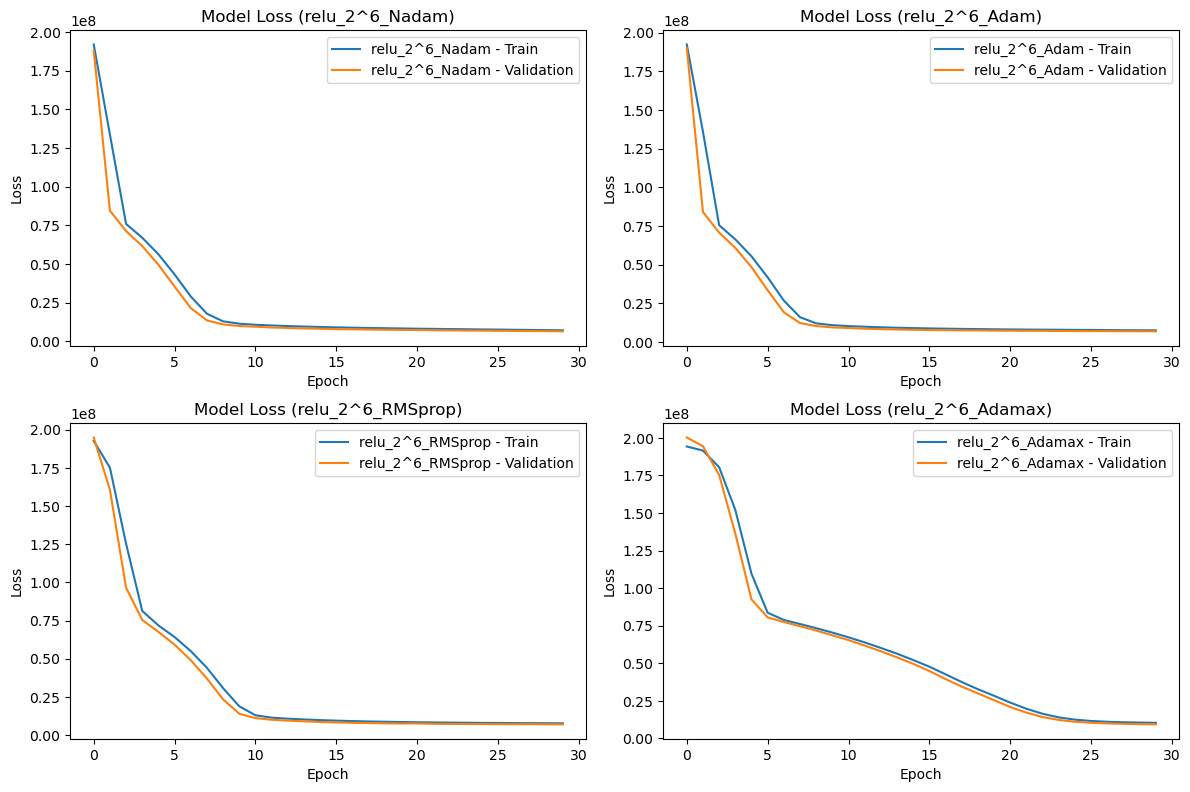

In [76]:
best_models = select_best_models(history)
plot_best_models(history, best_models)

<a name='12'></a>
## <span style="color:#ff5f27">👮🏻‍♂️ Model Evaluation</span>

In [77]:
best_model = models[best_models[0]]

In [78]:
preds_df = pd.DataFrame({
    'real_price': test_y,
    'predicted_price': np.round(best_model.predict(test_X).reshape(-1), 2)
})
preds_df['diff'] = np.round(preds_df['predicted_price'] - preds_df['real_price'],2)
print(f'💰Profit: {round(preds_df["diff"].sum(),2)}$ 🤩🤝📈🛥️💎')
preds_df.head()

22/22 [==============================] - 0s 885us/step
💰Profit: -22369.5$ 🤩🤝📈🛥️💎


,real_price,predicted_price,diff
1268,9688,9550.429688,-137.57
2093,11091,9745.110352,-1345.89
6442,9698,8773.839844,-924.16
531,14450,10775.530273,-3674.47
6552,28495,30224.820312,1729.82


In [79]:
def test_model(test_data, real_data, model):
    preds = model.predict(test_data)
    mae = mean_absolute_error(real_data, preds)
    r2 = r2_score(real_data, preds)
    return mae, r2

In [80]:
mae, r2 = test_model(test_X, test_y, best_model)

22/22 [==============================] - 0s 923us/step


In [81]:
print(f'⚙️ Best Model Architecture: {best_models[0]}')
print(f'⌛️ Fit Time: {round(time[best_models[0]],2)}sec')
print(f'⛳️ MAE: {round(mae,2)}')
print(f'⛳️ R2: {round(r2,2)}')

⚙️ Best Model Architecture: relu_2^6_Nadam
⌛️ Fit Time: 6.01sec
⛳️ MAE: 2015.07
⛳️ R2: 0.81


- [🗄️ Table of Contents](#0_0)
---